In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, KBinsDiscretizer, OneHotEncoder, Binarizer, \
    FunctionTransformer, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

In [15]:
heart_disease = pd.read_csv('heart_disease.csv')

# Data types

From https://archive.ics.uci.edu/dataset/45/heart+disease

| Variable Name | Code   | Role     | Type          | Demographic                | Description                                     | Units   | Missing Values |
|-----|--------|----------|---------------|----------------------------|-------------------------------------------------|---------|----------------|
| `age` | #3     | Feature  | Integer       | Age                        | Age in years                                   | years   | no             |
| `sex` | #4     | Feature  | Categorical   | Sex                        | Sex (1 = male; 0 = female)                     |         | no             |
| `cp` | #9     | Feature  | Categorical   |                            | Chest pain type: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic |         | no             |
| `trestbps` | #10    | Feature  | Integer       |                            | Resting blood pressure (in mm Hg on admission to the hospital) | mm Hg   | no             |
| `chol` | #12    | Feature  | Integer       |                            | Serum cholesterol in mg/dl                     | mg/dl   | no             |
| `fbs` | #16    | Feature  | Categorical   |                            | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false) |         | no             |
| `restecg` | #19    | Feature  | Categorical   |                            | Resting electrocardiographic results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy |         | no             |
| `thalach` | #32    | Feature  | Integer       |                            | Maximum heart rate achieved                    |         | no             |
| `exang`| #38    | Feature  | Categorical   |                            | Exercise-induced angina (1 = yes; 0 = no)      |         | no             |
| `oldpeak` | #40    | Feature  | Integer       |                            | ST depression induced by exercise relative to rest |         | no             |
| `slope`| #41    | Feature  | Categorical   |                            | Slope of the peak exercise ST segment: 1 = upsloping, 2 = flat, 3 = downsloping |         | no             |
| `ca`| #44    | Feature  | Integer       |                            | Number of major vessels (0–3) colored by fluoroscopy |         | yes            |
| `thal`| #51    | Feature  | Categorical   |                            | Thal: 3 = normal, 6 = fixed defect, 7 = reversible defect |         | yes            |
| `num`| #58    | Target   | Integer       |                            | Diagnosis of heart disease (angiographic disease status): 0 = <50% diameter narrowing, 1 = >50% |         | no             |

## Feature categorisation
Lets assign the column names to numeric or categorical features based on data description

In [16]:
numeric_features = [
    'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'
]
categorical_features = [
    'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'
]


## Missing data
The `ca` and `thal` features are flagged as missing values

In [23]:
heart_disease['ca'].value_counts()

ca
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: count, dtype: int64

In [24]:
heart_disease['thal'].value_counts()

thal
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64

Only a few missing values, easier to just drop the rows and convert the rest to ints

## Data cleaning pipeline
We want to create a pipeline for how the data will be transformed, and fit and encoded

### Drop rows with '?'
We'll make a function and transformer to drop the rows and convert to ints

In [ ]:
# Custom function to drop rows with missing values
def drop_missing_rows(X, string: str):
    if isinstance(X, pd.DataFrame):
        return X[~X.isin([string]).any(axis=1)]
    return X  #

# Create a transformer for dropping rows
drop_na_transformer = FunctionTransformer(drop_missing_rows, '?')

### Scaling
For the numeric features, we need to work out what transforms will be appropriate based upon their distributions

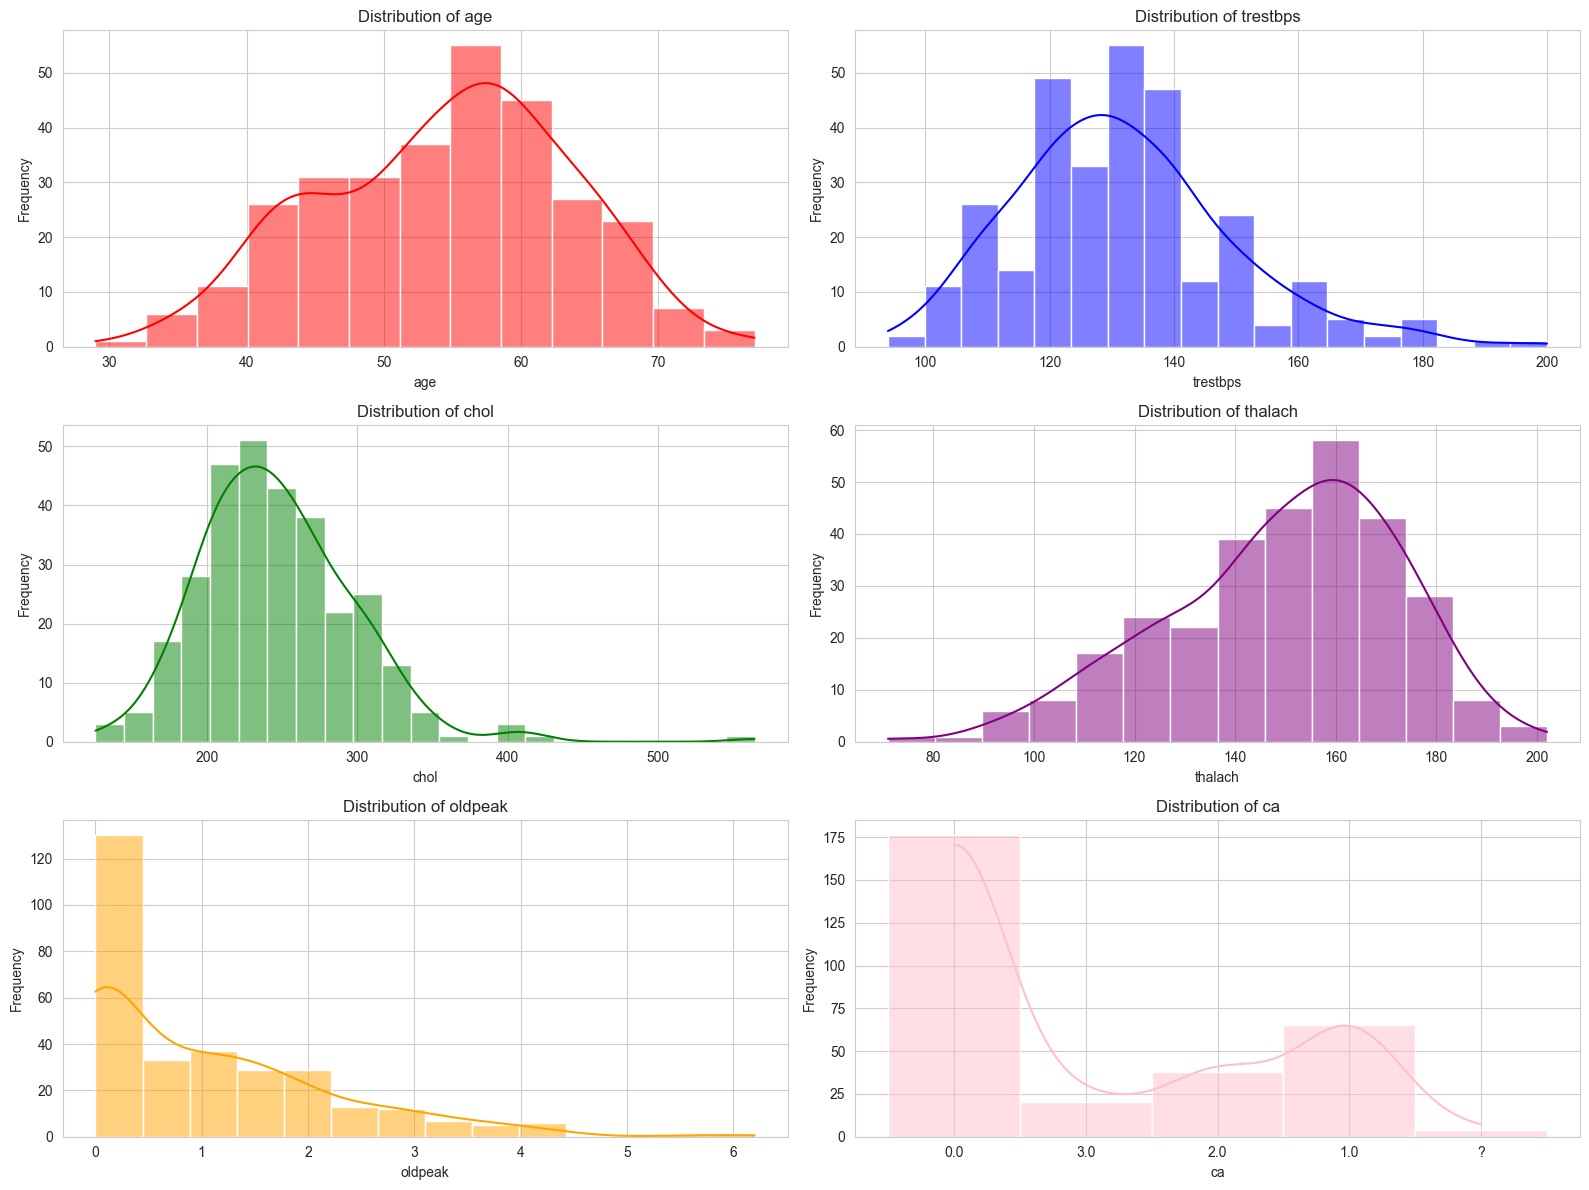

In [28]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']  # Define a list of colors for the plots

fig, axes = plt.subplots(nrows=(len(numeric_features) + 1) // 2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(numeric_features):
    sns.histplot(heart_disease[column], kde=True, bins="auto", color=colors[i % len(colors)], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Comments
Generally it appears as all these distributions contain one primary distribution, and a secondary smaller peak. `oldpeak` and `ca` are heavily skewed to the 0 result, because there are no negative results that make sense
### Scaling required
- `age`, `trestbps`, `thalach` are approximately normally distributed so StandardScaler will work fine
- `chol` appears to be right skewed, and has some outliers, we'll need to use RobustScaler
- `oldpeak` is heavily right skewed, so we'll need to use a MinMax or QuantileTransformer
- `ca` is also heavily right skewed, so we'll need to use a MinMax or QuantileTransformer


In [ ]:
scaling_encoding = {
    'num': {
        'age': StandardScaler(),
        'trestbps': StandardScaler(),
        'chol': RobustScaler(),
        'thalach': StandardScaler(),
        'oldpeak': MinMaxScaler(), # Since we have 0 values
        'ca': MinMaxScaler(), # Since we have 0 values
    },
    'cat': {
        'sex': OneHotEncoder(),
        'cp': OneHotEncoder(),
        'fbs': OneHotEncoder(),
        'restecg': OneHotEncoder(),
        'exang': OneHotEncoder(),
        'slope': OneHotEncoder(),
        'ca': OneHotEncoder(),
        'thal': OneHotEncoder(),
    }
}

# Create transformer lists from the dictionary
num_transformers = [(feature, scaler) for feature, scaler in scaling_encoding['num'].items()]
cat_transformers = [(feature, encoder) for feature, encoder in scaling_encoding['cat'].items()]

preprocessor = ColumnTransformer([
    ('drop_missing', drop_na_transformer), # Drop rows with '?' values
    ('numeric_columns_transform', ColumnTransformer(num_transformers, remainder='passthrough'), numeric_features),
    ('categorical_columns_transform', ColumnTransformer(cat_transformers, remainder='passthrough'), categorical_features),
])

def clean_column(df, column):
    df = df[df[column] != '?']  # Drops rows where the column is '?'
    df[column] = df[column].astype(int)
    return df

heart_disease = clean_column(heart_disease, 'ca')
heart_disease = clean_column(heart_disease, 'thal')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])